In [1]:
%matplotlib inline
import math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit
from scipy import signal
from os import path
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
plt.rc('text', usetex=True)

outpath = "../../../plots/temperatures"
inpath = "../../../"

currentfile = "Imitator_2_2400.csv"

# Read from file
strdatatype = np.dtype([('N', np.int_, (2,)), ('Time_Count', np.int_ ), ('Mode', np.int_ ),
                        ('T', np.float_, (10,)), ('S', np.bool_, (10,)), ('System_State', np.bool_ )])
N, Time_Count, Mode, T, S, System_State = np.loadtxt(path.join(inpath, currentfile), 
                                                     unpack=True, delimiter=';', skiprows=1, dtype=strdatatype)

In [3]:
max_possible_model_temperature = 15.0
min_possible_model_temperature = 70.0
def scale_T(_T):
    return (_T - min_possible_model_temperature) / (max_possible_model_temperature - min_possible_model_temperature)

def unscale_T(_T):
    return (_T) * (max_possible_model_temperature - min_possible_model_temperature) + min_possible_model_temperature

In [4]:
print("Min:", np.min(T))
print("Max:", np.max(T))

Min: 18.40911018644466
Max: 65.14203288058243


In [5]:
T[1,:]

array([45.75318031, 39.16584902, 43.56690816, 43.06170964, 43.96788118,
       46.17686177, 33.76846876, 44.39839526, 46.16541138, 51.17311   ])

In [6]:
tmp = scale_T(T[1,:])
tmp

array([0.44085127, 0.56062093, 0.48060167, 0.4897871 , 0.47331125,
       0.43314797, 0.65875511, 0.46548372, 0.43335616, 0.34230709])

In [7]:
unscale_T(tmp)

array([45.75318031, 39.16584902, 43.56690816, 43.06170964, 43.96788118,
       46.17686177, 33.76846876, 44.39839526, 46.16541138, 51.17311   ])

In [8]:
sT = scale_T(T)

In [9]:
sT[:, 0]

array([0.54021667, 0.44085127, 0.40730998, ..., 0.72793045, 0.58471149,
       0.48766345])

In [10]:
print("Min:", np.min(sT))
print("Max:", np.max(sT))

Min: 0.0883266748985012
Max: 0.9380161784282788


In [11]:
delta = np.amin(np.abs(sT[:-2, :] - sT[1:-1, :])) 

In [12]:
delta

2.1317509536489254e-06

In [13]:
#data augmintation -- 150 slightly tuned copies of T
agmntCount=500
agmntdT=np.zeros((agmntCount, np.size(sT[:,0]), np.size(sT[0,:])))
agmntdT[0,:,:] = sT
np.random.seed(0)
mu, sigma = 0, delta/2.0
for i in range(1, agmntCount):
    agmntdT[i] = agmntdT[0] + np.random.normal(mu, sigma, (np.size(sT[:,0]), np.size(sT[0,:])))

In [14]:
agmntdT[0]

array([[0.54021667, 0.65577633, 0.550259  , ..., 0.53329114, 0.53525912,
        0.42799849],
       [0.44085127, 0.56062093, 0.48060167, ..., 0.46548372, 0.43335616,
        0.34230709],
       [0.40730998, 0.52266703, 0.46367789, ..., 0.42774825, 0.41820337,
        0.32762735],
       ...,
       [0.72793045, 0.63309985, 0.72434066, ..., 0.55001523, 0.59737163,
        0.6965634 ],
       [0.58471149, 0.5366876 , 0.5562961 , ..., 0.46114309, 0.47338423,
        0.55688069],
       [0.48766345, 0.446996  , 0.47673323, ..., 0.3744143 , 0.4029212 ,
        0.48163992]])

In [15]:
agmntdT[1]

array([[0.54021855, 0.65577676, 0.55026004, ..., 0.53329098, 0.53525901,
        0.42799893],
       [0.44085142, 0.56062248, 0.48060248, ..., 0.4654835 , 0.43335649,
        0.34230618],
       [0.40730726, 0.52266773, 0.46367881, ..., 0.42774805, 0.418205  ,
        0.32762891],
       ...,
       [0.72793031, 0.63310006, 0.72433988, ..., 0.55001448, 0.59737125,
        0.6965635 ],
       [0.58471103, 0.53668627, 0.55629663, ..., 0.46114302, 0.47338532,
        0.5568801 ],
       [0.48766309, 0.44699768, 0.47673248, ..., 0.37441406, 0.402922  ,
        0.48164146]])

In [16]:
agmntdT.shape

(500, 2401, 10)

In [17]:
predictSteps = 20

In [18]:
#Keep dataset tail for validate prediction quality
cutFromTail = 60
#In order to have shifted and unshifted series with same shape
t = cutFromTail + predictSteps

In [19]:
inData = np.zeros((agmntCount, np.size(sT[:-t,0]), np.size(sT[0,:]) + 1))
for i in range(0, agmntCount):
    inData[i,:,0] = Mode[:-t] / np.amax(Mode[:-t])
    inData[i,:,1:]= agmntdT[i,:-t,:]

In [20]:
inData.shape

(500, 2321, 11)

In [21]:
outData = agmntdT[:,predictSteps:-cutFromTail,:]

In [22]:
outData.shape

(500, 2321, 10)

In [23]:
inData[5, predictSteps:predictSteps+5,:]

array([[0.25      , 0.35829044, 0.45176253, 0.35527062, 0.37376907,
        0.29363807, 0.41655104, 0.41365735, 0.39411611, 0.33955721,
        0.40022863],
       [0.5       , 0.34103476, 0.46968808, 0.35413653, 0.37371361,
        0.28430482, 0.41291291, 0.42029993, 0.39642863, 0.34163977,
        0.42943249],
       [0.        , 0.38792354, 0.52296814, 0.40454812, 0.42770041,
        0.31860256, 0.43424984, 0.44343977, 0.42658615, 0.37203601,
        0.47657288],
       [0.75      , 0.36313594, 0.50552297, 0.37512065, 0.40090854,
        0.30788896, 0.42426555, 0.40757817, 0.40021588, 0.34541541,
        0.52565074],
       [0.25      , 0.39871287, 0.50607966, 0.38205059, 0.42061885,
        0.32690288, 0.44832567, 0.43612983, 0.41931206, 0.36023047,
        0.57318277]])

In [24]:
outData[5,0:5,:]

array([[0.35829044, 0.45176253, 0.35527062, 0.37376907, 0.29363807,
        0.41655104, 0.41365735, 0.39411611, 0.33955721, 0.40022863],
       [0.34103476, 0.46968808, 0.35413653, 0.37371361, 0.28430482,
        0.41291291, 0.42029993, 0.39642863, 0.34163977, 0.42943249],
       [0.38792354, 0.52296814, 0.40454812, 0.42770041, 0.31860256,
        0.43424984, 0.44343977, 0.42658615, 0.37203601, 0.47657288],
       [0.36313594, 0.50552297, 0.37512065, 0.40090854, 0.30788896,
        0.42426555, 0.40757817, 0.40021588, 0.34541541, 0.52565074],
       [0.39871287, 0.50607966, 0.38205059, 0.42061885, 0.32690288,
        0.44832567, 0.43612983, 0.41931206, 0.36023047, 0.57318277]])

In [25]:
num_data = len(inData[0,:,0])
num_data

2321

In [26]:
train_split = 0.9

In [27]:
num_train = int(train_split * num_data)
num_train

2088

In [28]:
num_test = num_data - num_train
num_test

233

In [29]:
inData_train = inData[:, 0:num_train, :]
inData_test = inData[:, num_train:, :]
len(inData_train[0,:,0]) + len(inData_test[0,:,0])

2321

In [30]:
outData_train = outData[:, 0:num_train, :]
outData_test = outData[:, num_train:, :]
len(outData_train[0,:,0]) + len(outData_test[0,:,0])

2321

In [31]:
num_inData_signals = inData.shape[2]
num_inData_signals

11

In [32]:
num_outData_signals = outData.shape[2]
num_outData_signals

10

In [33]:
print("Min:", np.min(inData_train))
print("Max:", np.max(inData_train))

Min: 0.0
Max: 1.0


In [34]:
print("Min:", np.min(inData_train[:,:,1:]))
print("Max:", np.max(inData_train[:,:,1:]))

Min: 0.09172125889876331
Max: 0.9380193178126461


In [35]:
print(inData_train.shape)
print(outData_train.shape)

(500, 2088, 11)
(500, 2088, 10)


In [36]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        in_shape = (batch_size, sequence_length, num_inData_signals)
        in_batch = np.zeros(shape=in_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        out_shape = (batch_size, sequence_length, num_outData_signals)
        out_batch = np.zeros(shape=out_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # This points somewhere into the augmented series range.
            idaugmnt = np.random.randint(agmntCount)
            
            # Copy the sequences of data starting at this index.
            in_batch[i] = inData_train[idaugmnt, idx:idx+sequence_length]
            out_batch[i] = outData_train[idaugmnt, idx:idx+sequence_length]
        
        yield (in_batch, out_batch)

In [60]:
batch_size = 256

In [61]:
sequence_length=200

In [62]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [63]:
in_batch, out_batch = next(generator)

In [64]:
print(in_batch.shape)
print(out_batch.shape)

(256, 200, 11)
(256, 200, 10)


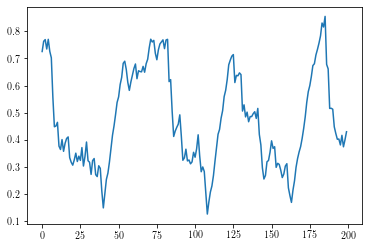

In [65]:
batch = 0   # First sequence in the batch.
signal = 1  # First signal from the 20 input-signals.
seq = in_batch[batch, :, signal]
plt.plot(seq)

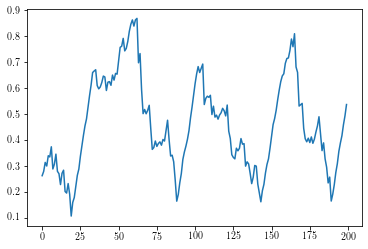

In [66]:
seq = out_batch[batch, :, signal]
plt.plot(seq)

In [67]:
validation_data = (np.expand_dims(inData_test[0,:,:], axis=0),
                   np.expand_dims(outData_test[0,:,:], axis=0))

In [68]:
model = Sequential()

In [69]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_inData_signals,)))

In [70]:
model.add(Dense(num_outData_signals, activation='sigmoid'))

In [71]:
warmup_steps = 5

In [72]:
#def loss_mse_warmup(y_true, y_pred):
#    """
#    Calculate the Mean Squared Error between y_true and y_pred,
#    but ignore the beginning "warmup" part of the sequences.
#    
#    y_true is the desired output.
#    y_pred is the model's output.
#    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
#    y_true_slice = y_true[:, warmup_steps:, :]
#    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
#    loss = tf.losses.mean_squared_error(labels=y_true_slice,
#                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
#    loss_mean = tf.reduce_mean(loss)

#    return loss_mean

In [73]:
#optimizer = RMSprop(lr=1e-3)

In [74]:
model.compile(Adam(), loss='mean_absolute_error')

In [75]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1987467144962095422
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3599302656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8891004492476611380
physical_device_desc: "device: 0, name: GeForce GTX 770, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [76]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         804864    
_________________________________________________________________
dense_2 (Dense)              (None, None, 10)          5130      
Total params: 809,994
Trainable params: 809,994
Non-trainable params: 0
_________________________________________________________________


In [77]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [78]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [79]:
#callback_tensorboard = keras.callbacks.TensorBoard(log_dir="logdir/")

In [80]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [81]:
callbacks = [callback_early_stopping,
            callback_checkpoint,
            callback_reduce_lr]

In [ ]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=1000,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 837/1000 [========================>.....] - ETA: 1:05 - loss: 0.0717